<a href="https://colab.research.google.com/github/Mohamed-Adel-l/Deep-Learning/blob/main/RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

tf.random.set_seed(42)
np.random.seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
with open("reduced_splits.pkl", "rb") as f:
    reduced_data = pickle.load(f)

train_texts_small = reduced_data["train_texts_small"]
val_texts_small = reduced_data["val_texts_small"]
test_texts_small = reduced_data["test_texts_small"]
train_labels_small = reduced_data["train_labels_small"]
val_labels_small = reduced_data["val_labels_small"]
test_labels_small = reduced_data["test_labels_small"]

print("Reduced data loaded successfully!")
print(f"Training samples: {len(train_texts_small)}")
print(f"Validation samples: {len(val_texts_small)}")
print(f"Test samples: {len(test_texts_small)}")

Reduced data loaded successfully!
Training samples: 50000
Validation samples: 10000
Test samples: 10000


In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    return text

print("Preprocessing training texts...")  # Apply preprocessing
train_texts_clean = [preprocess_text(text) for text in train_texts_small]

print("Preprocessing validation texts...")
val_texts_clean = [preprocess_text(text) for text in val_texts_small]

print("Preprocessing test texts...")
test_texts_clean = [preprocess_text(text) for text in test_texts_small]

print("\nSample original and cleaned text:")
for i in range(3):
    print(f"Original: {train_texts_small[i]}")
    print(f"Cleaned: {train_texts_clean[i]}\n")

Preprocessing training texts...
Preprocessing validation texts...
Preprocessing test texts...

Sample original and cleaned text:
Original: love mind
Cleaned: love mind

Original: enjoy supporting enough love spread around singers one awesomely adorable actor lt
Cleaned: enjoy supporting enough love spread around singer one awesomely adorable actor lt

Original: thankyou much wish fryer dumping arsehole
Cleaned: thankyou much wish fryer dumping arsehole



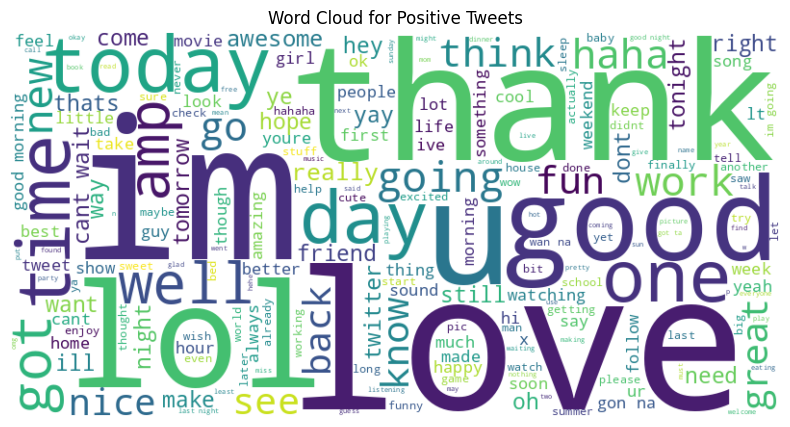

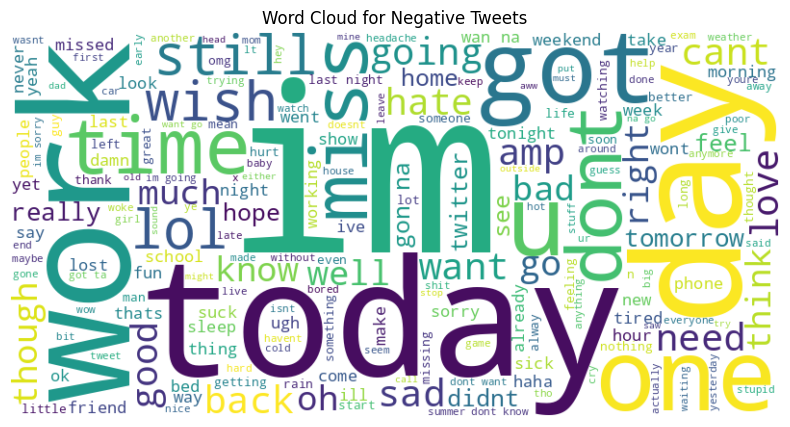

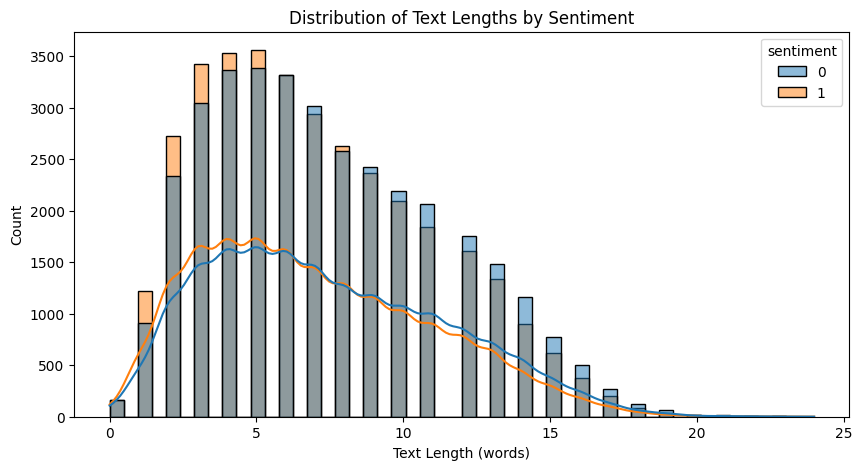

In [ ]:
all_clean_texts = train_texts_clean + val_texts_clean + test_texts_clean
all_labels = np.concatenate([train_labels_small, val_labels_small, test_labels_small])

viz_df = pd.DataFrame({'text': all_clean_texts, 'sentiment': all_labels})

positive_text = ' '.join(viz_df[viz_df['sentiment'] == 1]['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Tweets')
plt.show()

negative_text = ' '.join(viz_df[viz_df['sentiment'] == 0]['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Tweets')
plt.show()

viz_df['text_length'] = viz_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(data=viz_df, x='text_length', bins=50, hue='sentiment', kde=True)
plt.title('Distribution of Text Lengths by Sentiment')
plt.xlabel('Text Length (words)')
plt.ylabel('Count')
plt.show()

In [ ]:
max_words = 10000
max_len = 30

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_texts_clean)

X_train_seq = tokenizer.texts_to_sequences(train_texts_clean)
X_val_seq = tokenizer.texts_to_sequences(val_texts_clean)
X_test_seq = tokenizer.texts_to_sequences(test_texts_clean)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

y_train = np.array(train_labels_small)
y_val = np.array(val_labels_small)
y_test = np.array(test_labels_small)

print("Sample padded sequence:")
print(X_train_pad[0])
print("Corresponding label:", y_train[0])

Sample padded sequence:
[  9 375   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
Corresponding label: 1


In [ ]:
embedding_dim = 64
rnn_units = 32
dropout_rate = 0.3

rnn_model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(units=rnn_units, return_sequences=False),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
import time

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

batch_size = 64
epochs = 5

print("Training RNN model")
start_time = time.time()

rnn_history = rnn_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

end_time = time.time()
rnn_training_time = end_time - start_time
print(f"\nRNN Training completed in {rnn_training_time:.2f} seconds")

Training RNN model
Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8224 - loss: 0.4080 - val_accuracy: 0.7494 - val_loss: 0.5506 - learning_rate: 1.0000e-04
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8354 - loss: 0.3833 - val_accuracy: 0.7431 - val_loss: 0.5656 - learning_rate: 1.0000e-04
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8514 - loss: 0.3546 - val_accuracy: 0.7380 - val_loss: 0.5855 - learning_rate: 1.0000e-04
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8666 - loss: 0.3254 - val_accuracy: 0.7322 - val_loss: 0.6071 - learning_rate: 1.0000e-04

RNN Training completed in 63.02 seconds


In [ ]:
lstm_units = 32
lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(units=lstm_units, return_sequences=False)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
print("Training LSTM model")
start_time = time.time()

lstm_history = lstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

end_time = time.time()
lstm_training_time = end_time - start_time
print(f"\nLSTM Training completed in {lstm_training_time:.2f} seconds")

Training LSTM model
Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - accuracy: 0.6798 - loss: 0.5906 - val_accuracy: 0.7579 - val_loss: 0.4997 - learning_rate: 0.0010
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.7873 - loss: 0.4528 - val_accuracy: 0.7589 - val_loss: 0.5053 - learning_rate: 0.0010
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.8100 - loss: 0.4141 - val_accuracy: 0.7557 - val_loss: 0.5255 - learning_rate: 0.0010
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 56ms/step - accuracy: 0.8384 - loss: 0.3573 - val_accuracy: 0.7556 - val_loss: 0.5777 - learning_rate: 2.0000e-04

LSTM Training completed in 210.01 seconds


In [ ]:
from tabulate import tabulate
print("Evaluating RNN model")
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(X_test_pad, y_test, verbose=0)

print("Evaluating LSTM model")
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_pad, y_test, verbose=0)

rnn_training_time = len(rnn_history.history['loss'])
lstm_training_time = len(lstm_history.history['loss'])

table_data = [
    ["Metric", "SimpleRNN", "LSTM"],
    ["Training Time (sec)", f"{rnn_training_time:.2f}", f"{lstm_training_time:.2f}"],
    ["Training Epochs", len(rnn_history.history['loss']), len(lstm_history.history['loss'])],
    ["Training Accuracy", f"{max(rnn_history.history['accuracy']):.4f}", f"{max(lstm_history.history['accuracy']):.4f}"],
    ["Validation Accuracy", f"{max(rnn_history.history['val_accuracy']):.4f}", f"{max(lstm_history.history['val_accuracy']):.4f}"],
    ["Test Accuracy", f"{rnn_test_acc:.4f}", f"{lstm_test_acc:.4f}"],
    ["Test Loss", f"{rnn_test_loss:.4f}", f"{lstm_test_loss:.4f}"]
]

print("\nModel Comparison:")
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))

Evaluating RNN model
Evaluating LSTM model

Model Comparison:
╒═════════════════════╤═════════════╤════════╕
│ Metric              │   SimpleRNN │   LSTM │
╞═════════════════════╪═════════════╪════════╡
│ Training Time (sec) │      4      │ 4      │
├─────────────────────┼─────────────┼────────┤
│ Training Epochs     │      4      │ 4      │
├─────────────────────┼─────────────┼────────┤
│ Training Accuracy   │      0.8785 │ 0.8484 │
├─────────────────────┼─────────────┼────────┤
│ Validation Accuracy │      0.7494 │ 0.7589 │
├─────────────────────┼─────────────┼────────┤
│ Test Accuracy       │      0.7464 │ 0.7553 │
├─────────────────────┼─────────────┼────────┤
│ Test Loss           │      0.5429 │ 0.5    │
╘═════════════════════╧═════════════╧════════╛
